## Dependencies

In [1]:
# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_lags, make_lags, make_leads
from learntools.time_series.utils import plot_periodogram, seasonal_plot
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

import os
import pandas as pd
import numpy as np
from datetime import date
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(18, 7))

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import product
import gc

# Reading data

In [2]:
# Read the dataset
data_dir = Path('../input/competitive-data-science-predict-future-sales')

sales = pd.read_csv (data_dir / 'sales_train.csv',
                   parse_dates=['date'],
                   dayfirst=True,
                   infer_datetime_format=True,)

categories = pd.read_csv(data_dir / 'item_categories.csv')
items = pd.read_csv(data_dir / 'items.csv')
shops = pd.read_csv(data_dir / 'shops.csv')
sample = pd.read_csv(data_dir / 'sample_submission.csv')
test_data = pd.read_csv(data_dir / 'test.csv')

# EDA

In [3]:
sales.head(5)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0

In [4]:
sales.shape

(2935849, 6)

In [5]:
sales.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [6]:
print("Count of observations",len(sales))
sales.describe(include='all')

Count of observations 2935849


date  date_block_num       shop_id       item_id  \
count               2935849    2.935849e+06  2.935849e+06  2.935849e+06   
unique                 1034             NaN           NaN           NaN   
top     2013-12-28 00:00:00             NaN           NaN           NaN   
freq                   9434             NaN           NaN           NaN   
first   2013-01-01 00:00:00             NaN           NaN           NaN   
last    2015-10-31 00:00:00             NaN           NaN           NaN   
mean                    NaN    1.456991e+01  3.300173e+01  1.019723e+04   
std                     NaN    9.422988e+00  1.622697e+01  6.324297e+03   
min                     NaN    0.000000e+00  0.000000e+00  0.000000e+00   
25%                     NaN    7.000000e+00  2.200000e+01  4.476000e+03   
50%                     NaN    1.400000e+01  3.100000e+01  9.343000e+03   
75%                     NaN    2.300000e+01  4.700000e+01  1.568400e+04   
max                     NaN    3.300000e+01  5.900000e+01  2.216900e+04   

          item_price  item_cnt_day  
count   2.935849e+06  2.935849e+06  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
first            NaN           NaN  
last             NaN           NaN  
mean    8.908532e+02  1.242641e+00  
std     1.729800e+03  2.618834e+00  
min    -1.000000e+00 -2.200000e+01  
25%     2.490000e+02  1.000000e+00  
50%     3.990000e+02  1.000000e+00  
75%     9.990000e+02  1.000000e+00  
max     3.079800e+05  2.169000e+03

In [7]:
#Check for nan/nulls in the data
print ('Count of NaN values is: ',sales.isnull().sum().sum())
sales.isnull().values.any()

Count of NaN values is:  0


False

In [8]:
pt = pd.pivot_table(data=sales, 
                    index = ['shop_id', 'item_id'], 
                    values = 'item_cnt_day', 
                    columns = ['date_block_num'], 
                    aggfunc = np.sum, 
                    fill_value = 0)

pt.reset_index(inplace = True)
pt

date_block_num  shop_id  item_id  0   1  2  3  4  5  6  7  ...  24  25  26  \
0                     0       30  0  31  0  0  0  0  0  0  ...   0   0   0   
1                     0       31  0  11  0  0  0  0  0  0  ...   0   0   0   
2                     0       32  6  10  0  0  0  0  0  0  ...   0   0   0   
3                     0       33  3   3  0  0  0  0  0  0  ...   0   0   0   
4                     0       35  1  14  0  0  0  0  0  0  ...   0   0   0   
...                 ...      ... ..  .. .. .. .. .. .. ..  ...  ..  ..  ..   
424119               59    22154  1   0  0  0  0  0  0  0  ...   0   0   0   
424120               59    22155  0   0  0  0  0  0  1  0  ...   0   0   0   
424121               59    22162  0   0  0  0  0  0  0  0  ...   0   9   4   
424122               59    22164  0   0  0  0  0  0  0  0  ...   0   2   1   
424123               59    22167  0   0  0  0  0  0  0  0  ...   0   0   0   

date_block_num  27  28  29  30  31  32  33  
0                0   0   0   0   0   0   0  
1                0   0   0   0   0   0   0  
2                0   0   0   0   0   0   0  
3                0   0   0   0   0   0   0  
4                0   0   0   0   0   0   0  
...             ..  ..  ..  ..  ..  ..  ..  
424119           0   0   0   0   0   0   0  
424120           0   0   0   0   0   0   0  
424121           1   1   0   0   1   0   0  
424122           2   0   0   1   0   0   0  
424123           0   0   0   0   0   0   0  

[424124 rows x 36 columns]

In [9]:
#Check for nan/nulls in the pivot table
print ('Count of NaN: ',pt.isnull().sum().sum())
pt.isnull().values.any()

Count of NaN:  0


False

In [10]:
test_data

ID  shop_id  item_id
0            0        5     5037
1            1        5     5320
2            2        5     5233
3            3        5     5232
4            4        5     5268
...        ...      ...      ...
214195  214195       45    18454
214196  214196       45    16188
214197  214197       45    15757
214198  214198       45    19648
214199  214199       45      969

[214200 rows x 3 columns]

In [11]:
sales

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0       2013-01-02               0       59    22154      999.00           1.0
1       2013-01-03               0       25     2552      899.00           1.0
2       2013-01-05               0       25     2552      899.00          -1.0
3       2013-01-06               0       25     2554     1709.05           1.0
4       2013-01-15               0       25     2555     1099.00           1.0
...            ...             ...      ...      ...         ...           ...
2935844 2015-10-10              33       25     7409      299.00           1.0
2935845 2015-10-09              33       25     7460      299.00           1.0
2935846 2015-10-14              33       25     7459      349.00           1.0
2935847 2015-10-22              33       25     7440      299.00           1.0
2935848 2015-10-03              33       25     7460      299.00           1.0

[2935849 rows x 6 columns]

In [12]:
items_sold_per_day = sales.groupby('date').agg({'item_cnt_day': 'sum'}).reset_index()

In [13]:
items_sold_per_day['time'] = np.arange(len(items_sold_per_day))

In [14]:
items_sold_per_day

date  item_cnt_day  time
0    2013-01-01        1951.0     0
1    2013-01-02        8198.0     1
2    2013-01-03        7422.0     2
3    2013-01-04        6617.0     3
4    2013-01-05        6346.0     4
...         ...           ...   ...
1029 2015-10-27        1551.0  1029
1030 2015-10-28        3593.0  1030
1031 2015-10-29        1589.0  1031
1032 2015-10-30        2274.0  1032
1033 2015-10-31        3104.0  1033

[1034 rows x 3 columns]

## Fit a time-step feature

In [15]:
X = items_sold_per_day.loc[:, ['time']]  # features
y = items_sold_per_day.loc[:, 'item_cnt_day']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Storing the fitted values as a time series with the same time index of item_counts as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

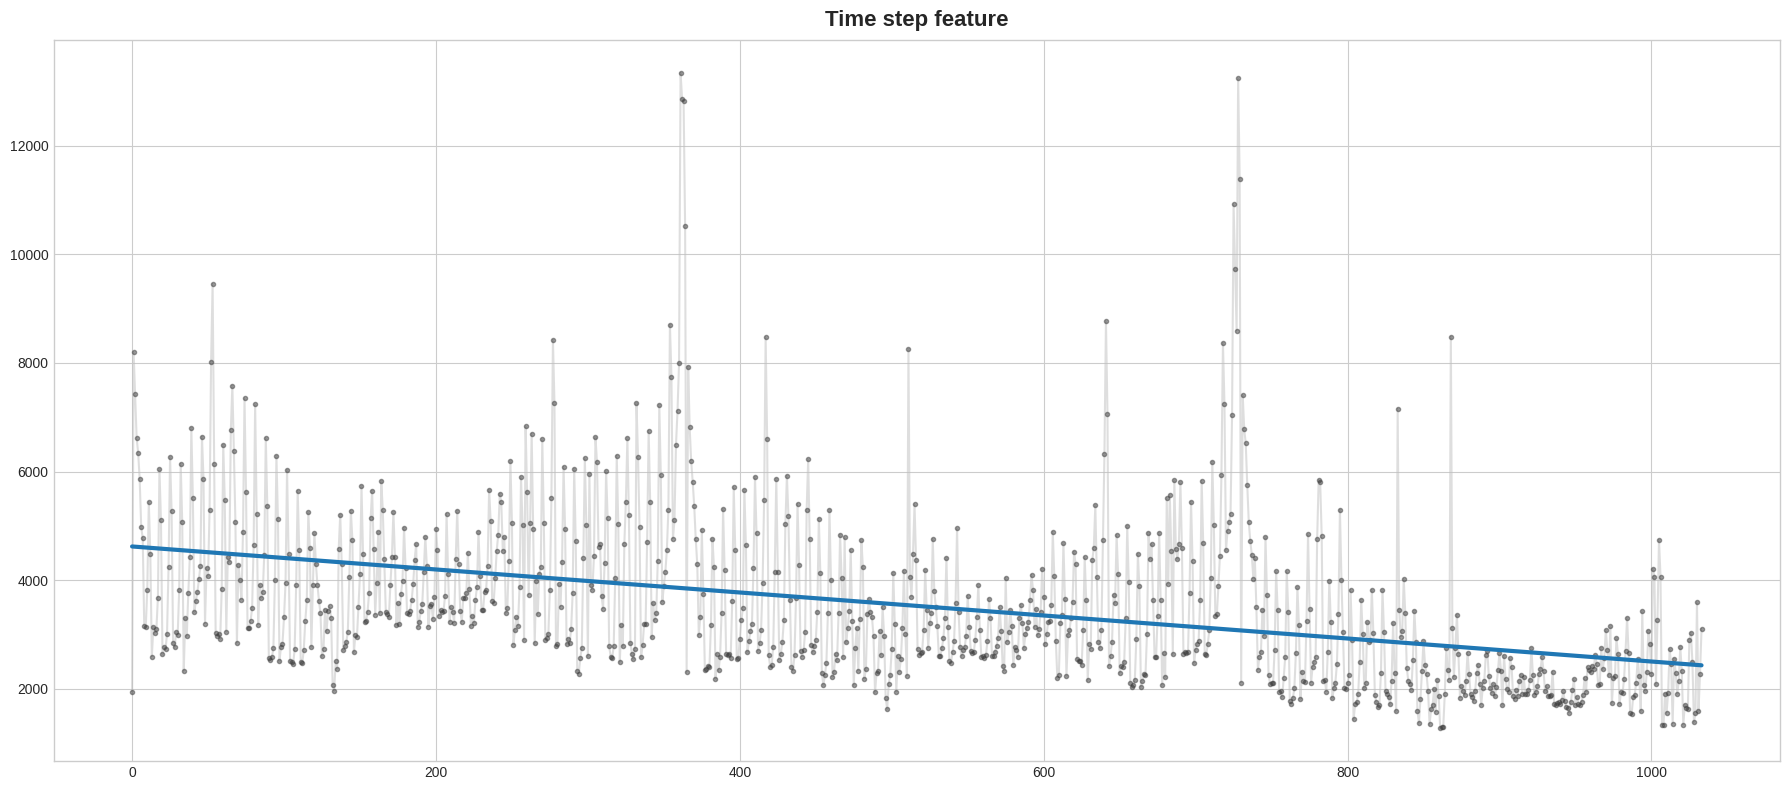

In [16]:
plt.figure(figsize=(18,8))
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time step feature');

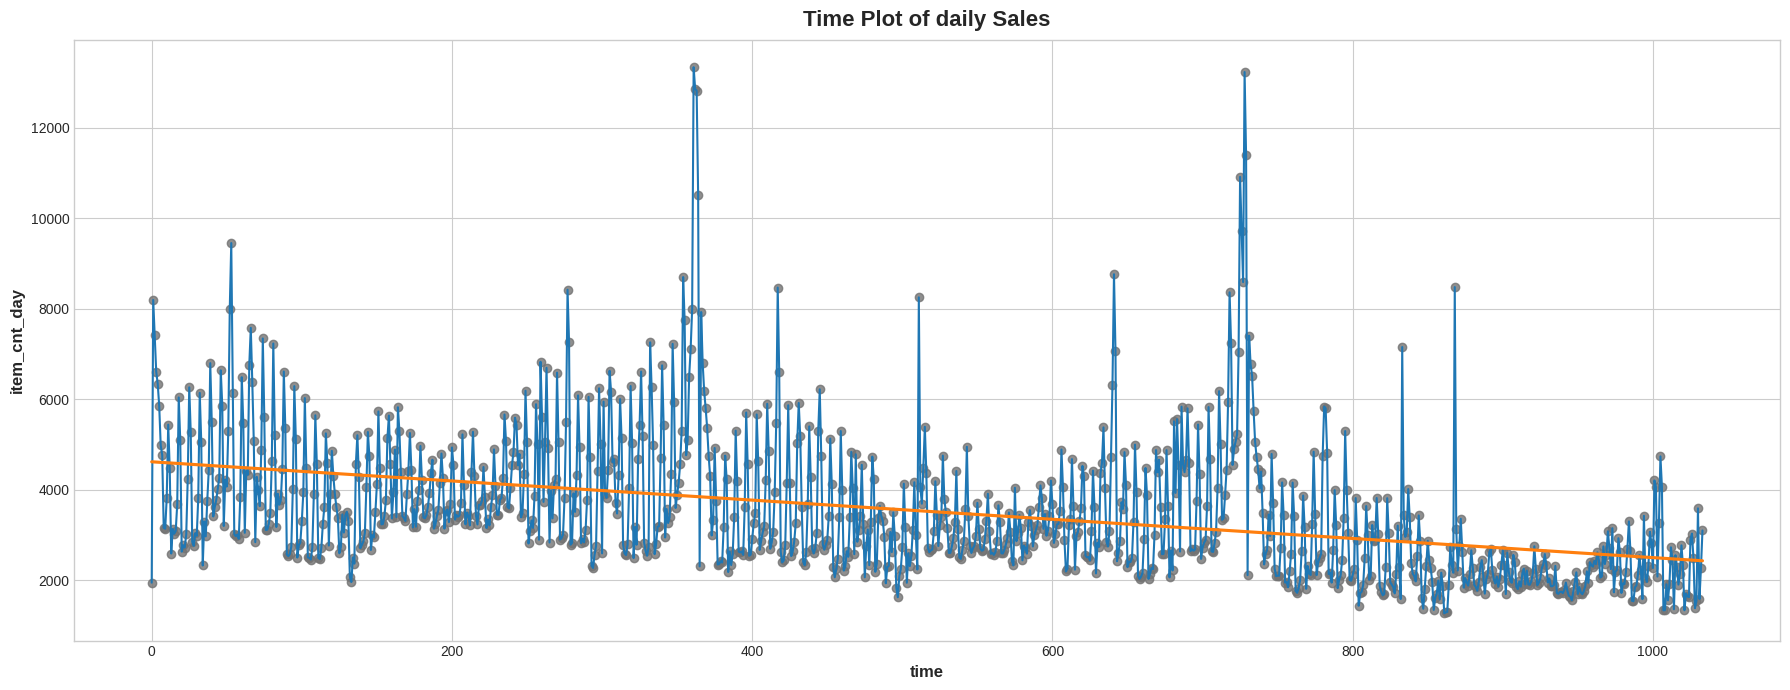

In [17]:
fig, ax = plt.subplots()
ax.plot('time', 'item_cnt_day', data=items_sold_per_day)
ax = sns.regplot(x='time', y='item_cnt_day', 
                 data=items_sold_per_day, ci=None, scatter_kws=dict(color='0.45'))
ax.set_title('Time Plot of daily Sales');

## Fit a lag feature to Store Sales

In [18]:
lf = items_sold_per_day.copy()

# Create a lag feature from the target 'sales'
lag_1 = lf['item_cnt_day'].shift(1)

lf['lag_1'] = lag_1  # add to dataframe

X = lf.loc[:, ['lag_1']].dropna()  # features
y = lf.loc[:, 'item_cnt_day']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

# the same time indeitem_counts as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

In [19]:
lf = lf.dropna()
lf

date  item_cnt_day  time   lag_1
1    2013-01-02        8198.0     1  1951.0
2    2013-01-03        7422.0     2  8198.0
3    2013-01-04        6617.0     3  7422.0
4    2013-01-05        6346.0     4  6617.0
5    2013-01-06        5858.0     5  6346.0
...         ...           ...   ...     ...
1029 2015-10-27        1551.0  1029  1387.0
1030 2015-10-28        3593.0  1030  1551.0
1031 2015-10-29        1589.0  1031  3593.0
1032 2015-10-30        2274.0  1032  1589.0
1033 2015-10-31        3104.0  1033  2274.0

[1033 rows x 4 columns]

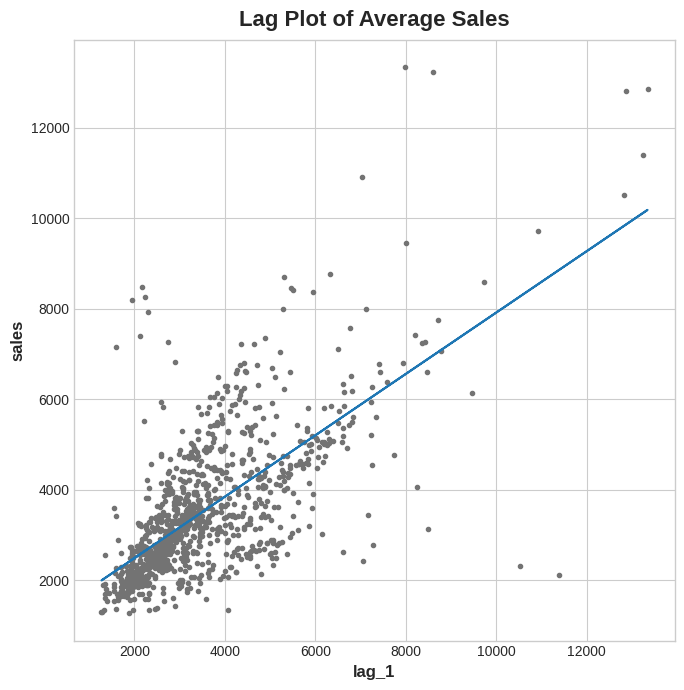

In [20]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.45')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', 
       title='Lag Plot of Average Sales');

# Trend

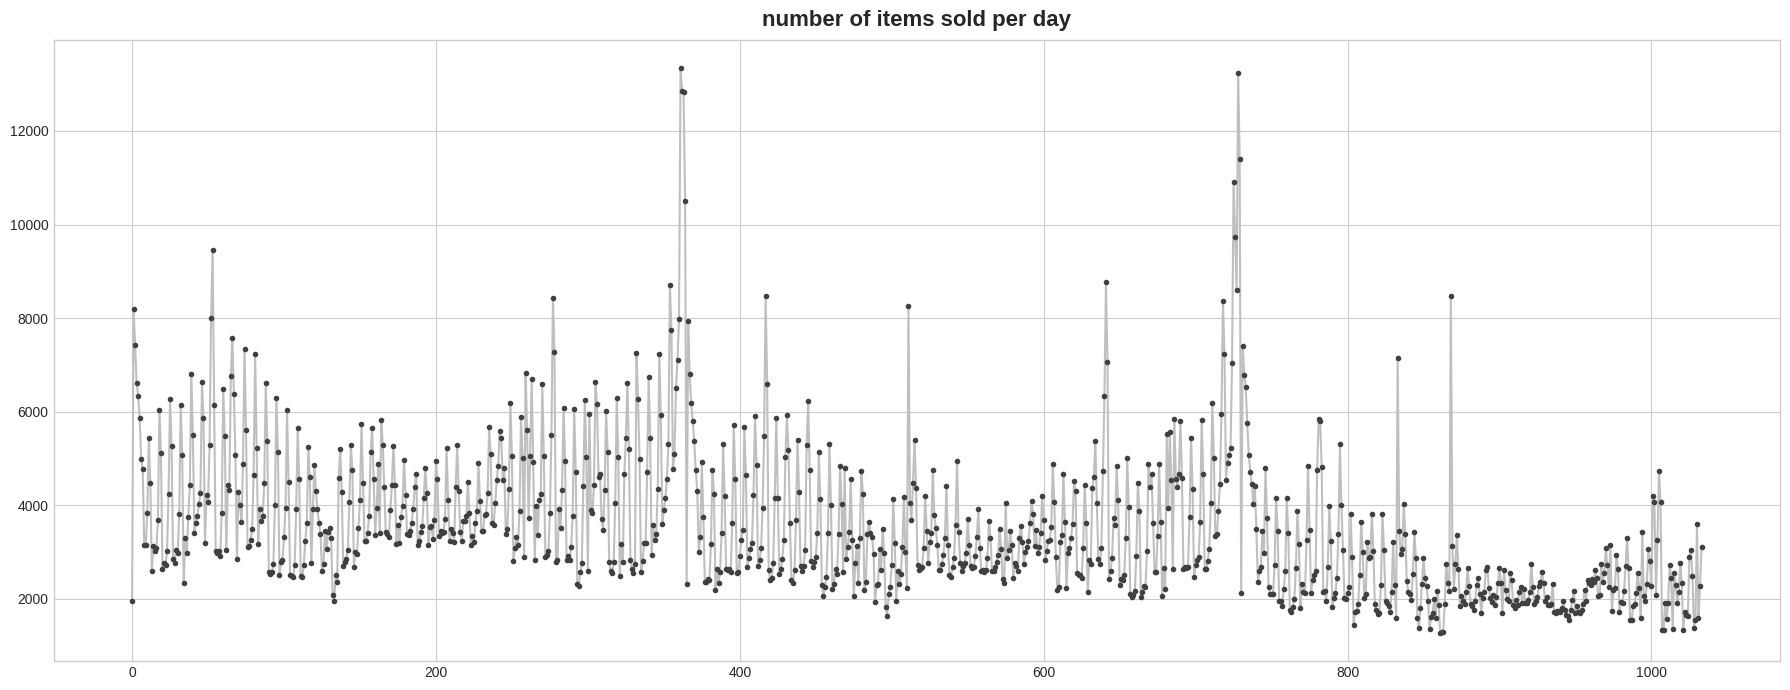

In [21]:
ax = items_sold_per_day.loc[:, ['item_cnt_day']].plot(**plot_params)
ax.set(title="number of items sold per day");

Now let's make a moving average plot to estimate the trend for this series.

<Figure size 1800x900 with 0 Axes>

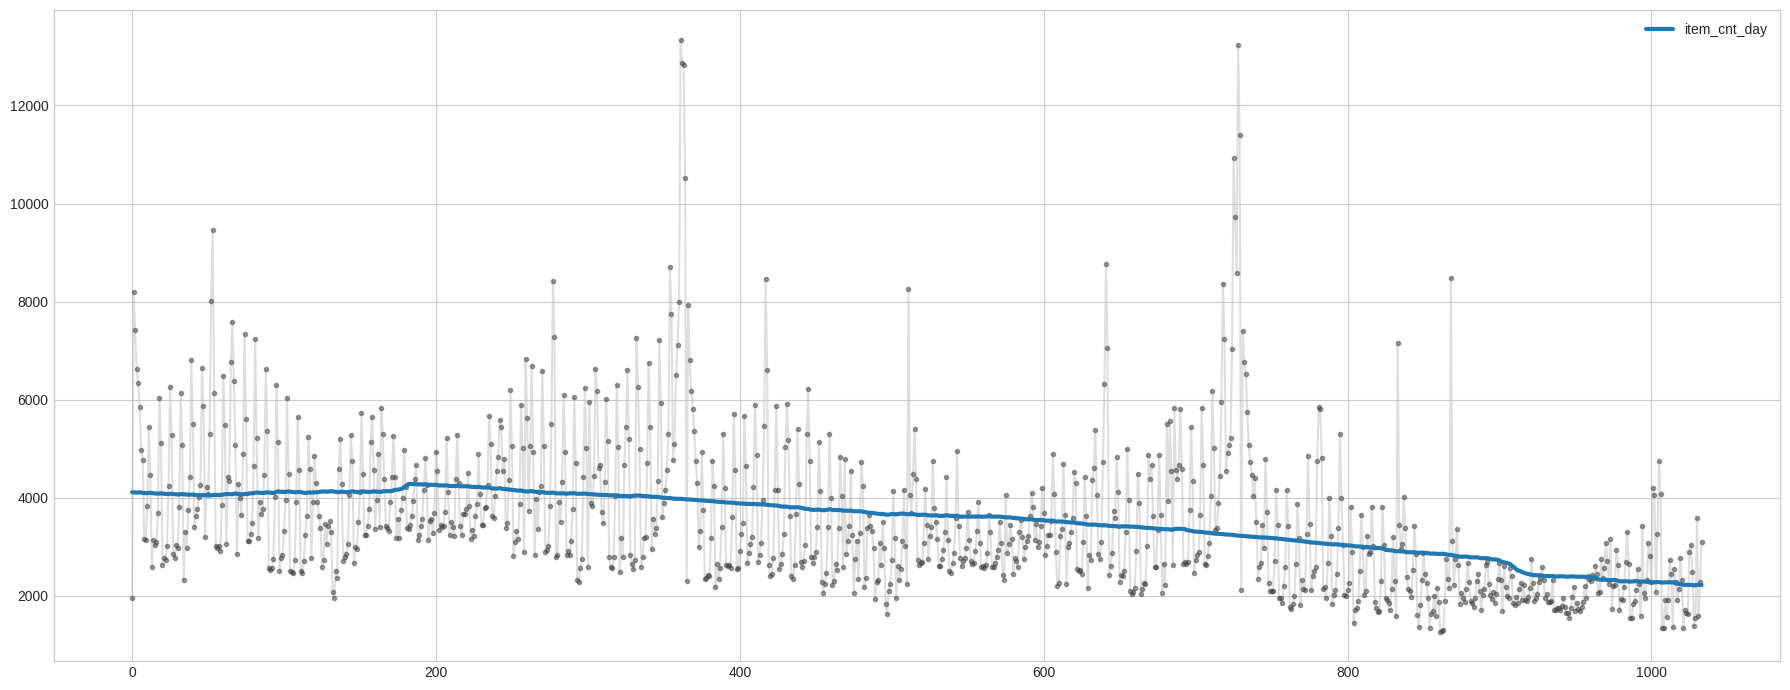

In [22]:
# average with appropriate parameters for trend estimation.
trend = items_sold_per_day.loc[:, ['item_cnt_day']].rolling(
    window=365,
    center=True,
    min_periods=183  
).mean()

# Make a plot
plt.figure(figsize=(18,9))
ax = items_sold_per_day.loc[:, ['item_cnt_day']].plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

## Create a Trend Feature

In [23]:
y = items_sold_per_day.loc[:, 'item_cnt_day'].copy()  # the target

# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index = items_sold_per_day.index,
    constant=False,
    order=3,
    drop=True
)
# Create the feature set for the dates given in y.indeitem_counts
X = dp.in_sample()

# Create features for a 30-day forecast.
X_fore = dp.out_of_sample(steps=30)


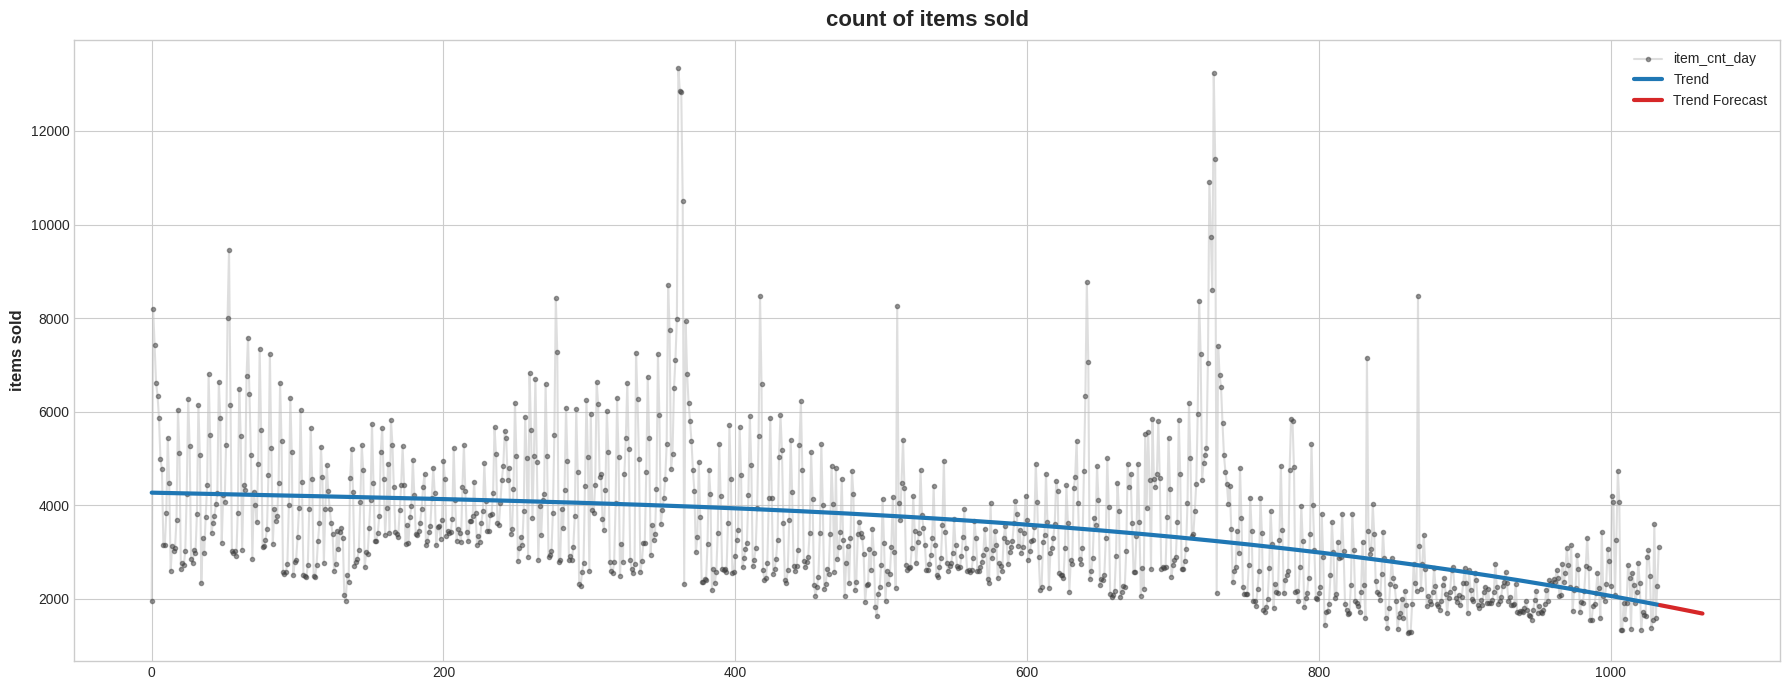

In [24]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="count of items sold", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

# Seasonality

In [25]:
items_sold_per_day

date  item_cnt_day  time
0    2013-01-01        1951.0     0
1    2013-01-02        8198.0     1
2    2013-01-03        7422.0     2
3    2013-01-04        6617.0     3
4    2013-01-05        6346.0     4
...         ...           ...   ...
1029 2015-10-27        1551.0  1029
1030 2015-10-28        3593.0  1030
1031 2015-10-29        1589.0  1031
1032 2015-10-30        2274.0  1032
1033 2015-10-31        3104.0  1033

[1034 rows x 3 columns]

In [26]:
items_sold_per_day = items_sold_per_day.set_index('date').to_period("D")

In [27]:
items_sold_per_day

item_cnt_day  time
date                          
2013-01-01        1951.0     0
2013-01-02        8198.0     1
2013-01-03        7422.0     2
2013-01-04        6617.0     3
2013-01-05        6346.0     4
...                  ...   ...
2015-10-27        1551.0  1029
2015-10-28        3593.0  1030
2015-10-29        1589.0  1031
2015-10-30        2274.0  1032
2015-10-31        3104.0  1033

[1034 rows x 2 columns]

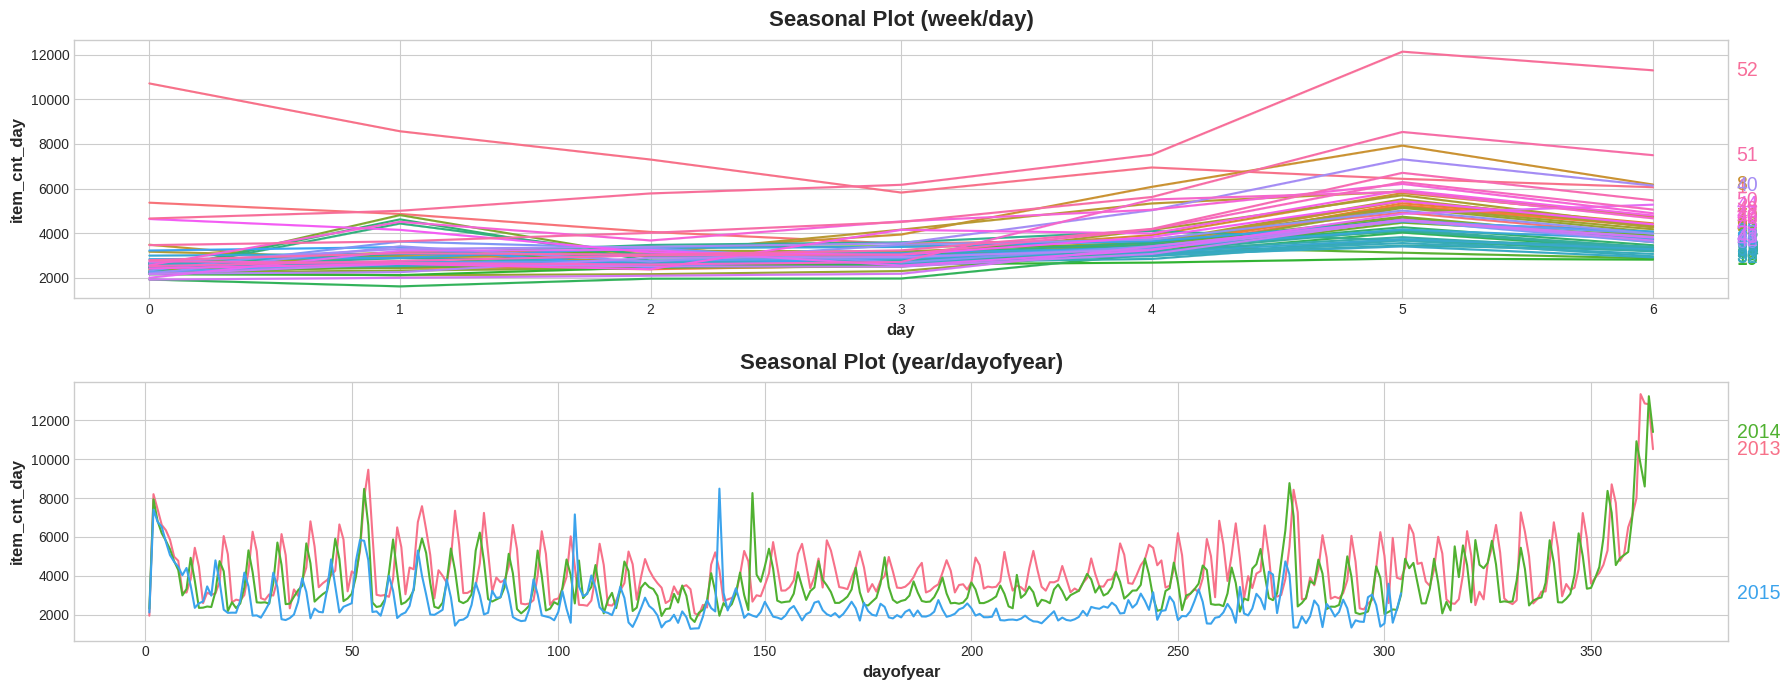

In [28]:
# days within a week
items_sold_per_day["week"] = items_sold_per_day.index.week
items_sold_per_day["day"] = items_sold_per_day.index.dayofweek

# days within a year
items_sold_per_day["dayofyear"] = items_sold_per_day.index.dayofyear
items_sold_per_day["year"] = items_sold_per_day.index.year

fig, (ax0, ax1) = plt.subplots(2, 1)
seasonal_plot(items_sold_per_day, y="item_cnt_day", period="week", freq="day", ax=ax0)
seasonal_plot(items_sold_per_day, y="item_cnt_day", period="year", freq="dayofyear", ax=ax1);

In [29]:
items_sold_per_day

item_cnt_day  time  week  day  dayofyear  year
date                                                      
2013-01-01        1951.0     0     1    1          1  2013
2013-01-02        8198.0     1     1    2          2  2013
2013-01-03        7422.0     2     1    3          3  2013
2013-01-04        6617.0     3     1    4          4  2013
2013-01-05        6346.0     4     1    5          5  2013
...                  ...   ...   ...  ...        ...   ...
2015-10-27        1551.0  1029    44    1        300  2015
2015-10-28        3593.0  1030    44    2        301  2015
2015-10-29        1589.0  1031    44    3        302  2015
2015-10-30        2274.0  1032    44    4        303  2015
2015-10-31        3104.0  1033    44    5        304  2015

[1034 rows x 6 columns]

Now let's look at the periodogram:

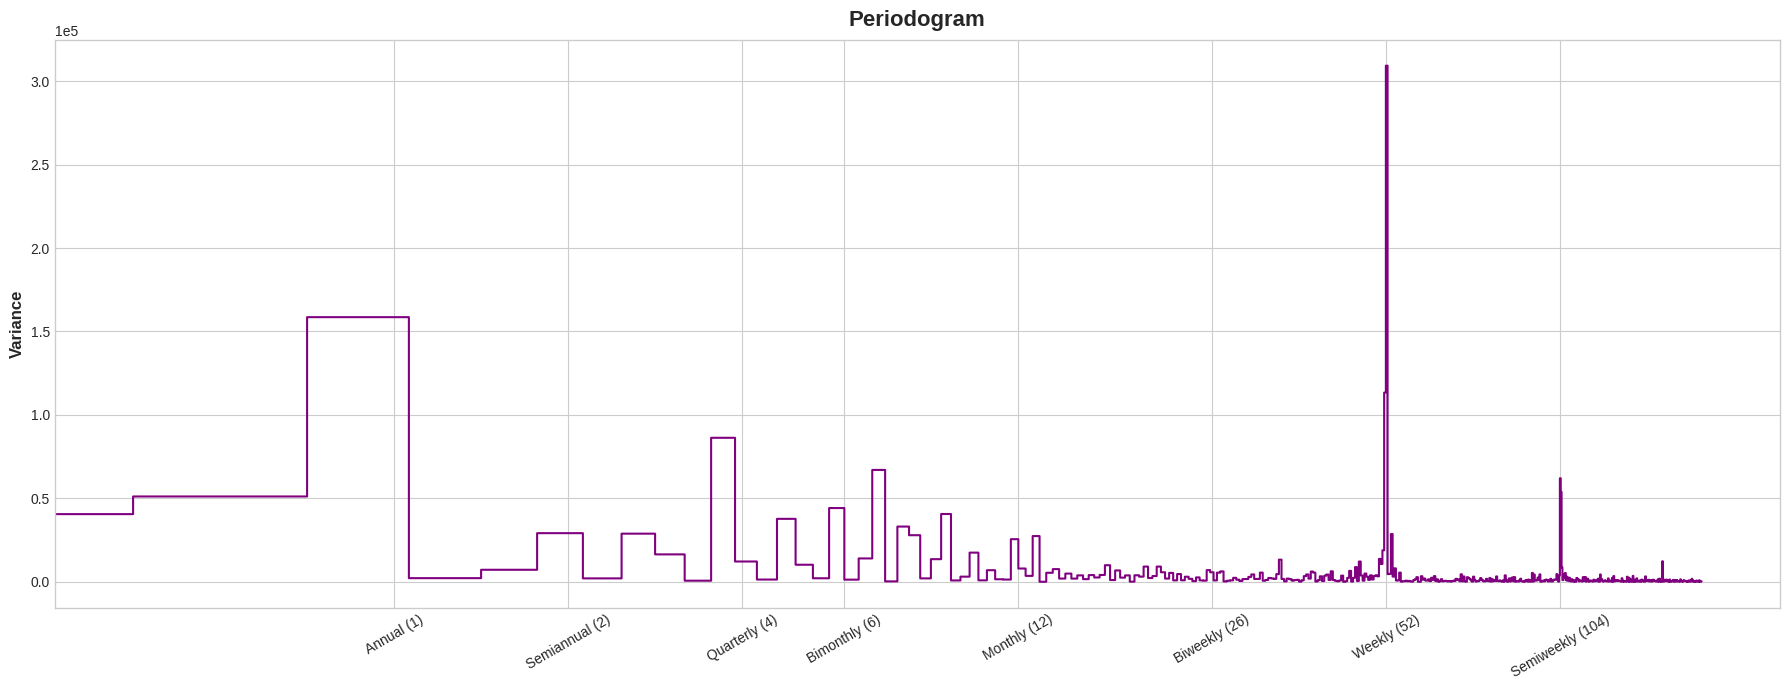

In [30]:
plot_periodogram(items_sold_per_day['item_cnt_day']);

How many Fourier pairs should we actually include in our feature set? We can answer this question with the periodogram. The periodogram tells us the strength of the frequencies in a time series.

## Create seasonal features

In [31]:
items_sold_per_day

item_cnt_day  time  week  day  dayofyear  year
date                                                      
2013-01-01        1951.0     0     1    1          1  2013
2013-01-02        8198.0     1     1    2          2  2013
2013-01-03        7422.0     2     1    3          3  2013
2013-01-04        6617.0     3     1    4          4  2013
2013-01-05        6346.0     4     1    5          5  2013
...                  ...   ...   ...  ...        ...   ...
2015-10-27        1551.0  1029    44    1        300  2015
2015-10-28        3593.0  1030    44    2        301  2015
2015-10-29        1589.0  1031    44    3        302  2015
2015-10-30        2274.0  1032    44    4        303  2015
2015-10-31        3104.0  1033    44    5        304  2015

[1034 rows x 6 columns]

In [32]:
y = items_sold_per_day['item_cnt_day'].copy()
fourier = CalendarFourier(freq='A', order=12)
dp = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)
X = dp.in_sample()

In [33]:
X.head()

const  trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                       
2013-01-01    1.0    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2013-01-02    1.0    2.0     1.0     0.0     0.0     0.0     0.0     0.0   
2013-01-03    1.0    3.0     0.0     1.0     0.0     0.0     0.0     0.0   
2013-01-04    1.0    4.0     0.0     0.0     1.0     0.0     0.0     0.0   
2013-01-05    1.0    5.0     0.0     0.0     0.0     1.0     0.0     0.0   

            sin(1,freq=A-DEC)  cos(1,freq=A-DEC)  ...  sin(8,freq=A-DEC)  \
date                                              ...                      
2013-01-01           0.000000           1.000000  ...           0.000000   
2013-01-02           0.017213           0.999852  ...           0.137279   
2013-01-03           0.034422           0.999407  ...           0.271958   
2013-01-04           0.051620           0.998667  ...           0.401488   
2013-01-05           0.068802           0.997630  ...           0.523416   

            cos(8,freq=A-DEC)  sin(9,freq=A-DEC)  cos(9,freq=A-DEC)  \
date                                                                  
2013-01-01           1.000000           0.000000           1.000000   
2013-01-02           0.990532           0.154309           0.988023   
2013-01-03           0.962309           0.304921           0.952378   
2013-01-04           0.915864           0.448229           0.893919   
2013-01-05           0.852078           0.580800           0.814046   

            sin(10,freq=A-DEC)  cos(10,freq=A-DEC)  sin(11,freq=A-DEC)  \
date                                                                     
2013-01-01            0.000000            1.000000            0.000000   
2013-01-02            0.171293            0.985220            0.188227   
2013-01-03            0.337523            0.941317            0.369725   
2013-01-04            0.493776            0.869589            0.538005   
2013-01-05            0.635432            0.772157            0.687053   

            cos(11,freq=A-DEC)  sin(12,freq=A-DEC)  cos(12,freq=A-DEC)  
date                                                                    
2013-01-01            1.000000            0.000000            1.000000  
2013-01-02            0.982126            0.205104            0.978740  
2013-01-03            0.929141            0.401488            0.915864  
2013-01-04            0.842942            0.580800            0.814046  
2013-01-05            0.726608            0.735417            0.677615  

[5 rows x 32 columns]

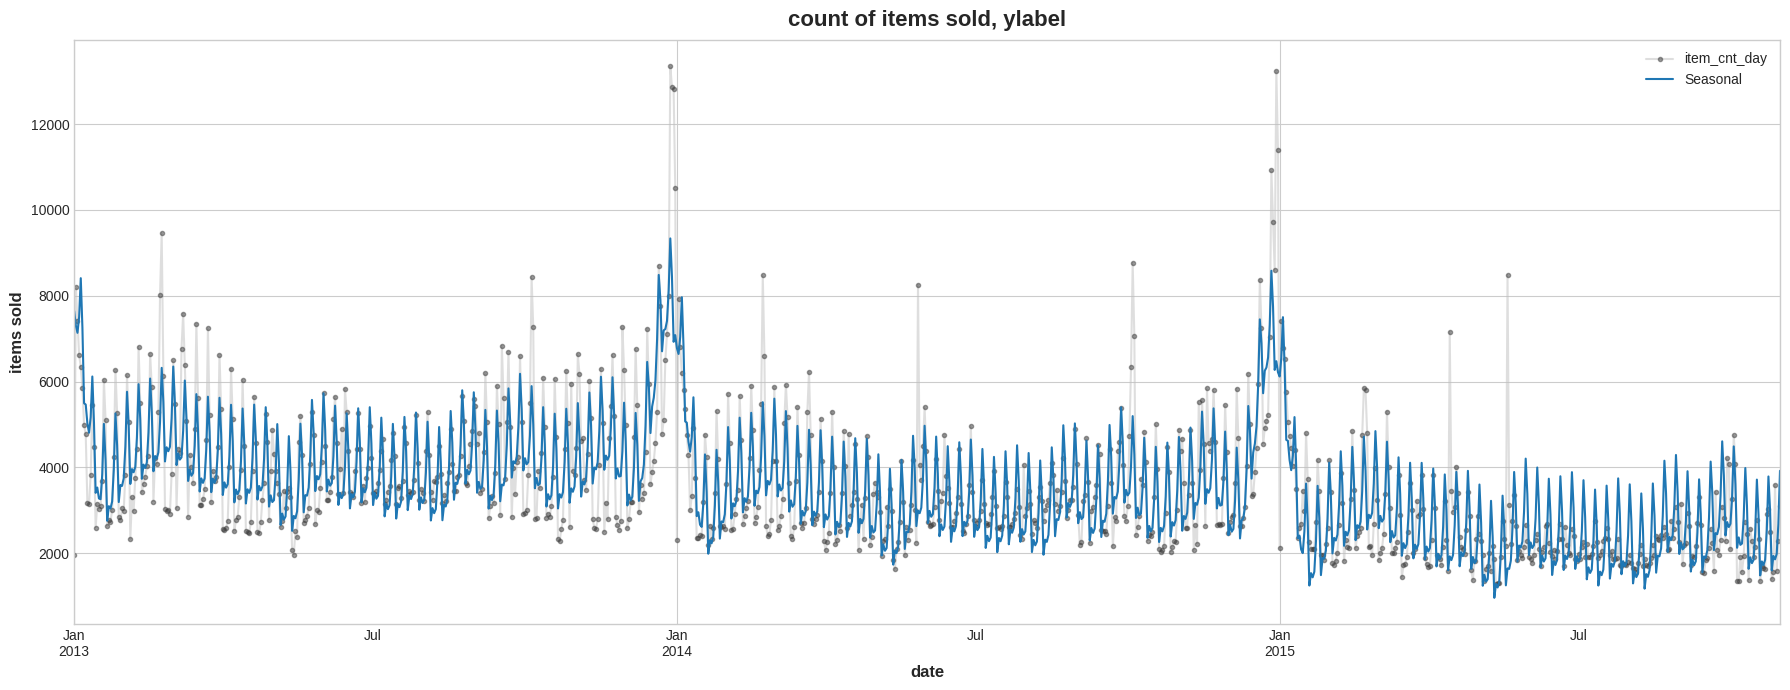

In [34]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="count of items sold, ylabel", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [35]:
X_fore = dp.out_of_sample(steps=90)

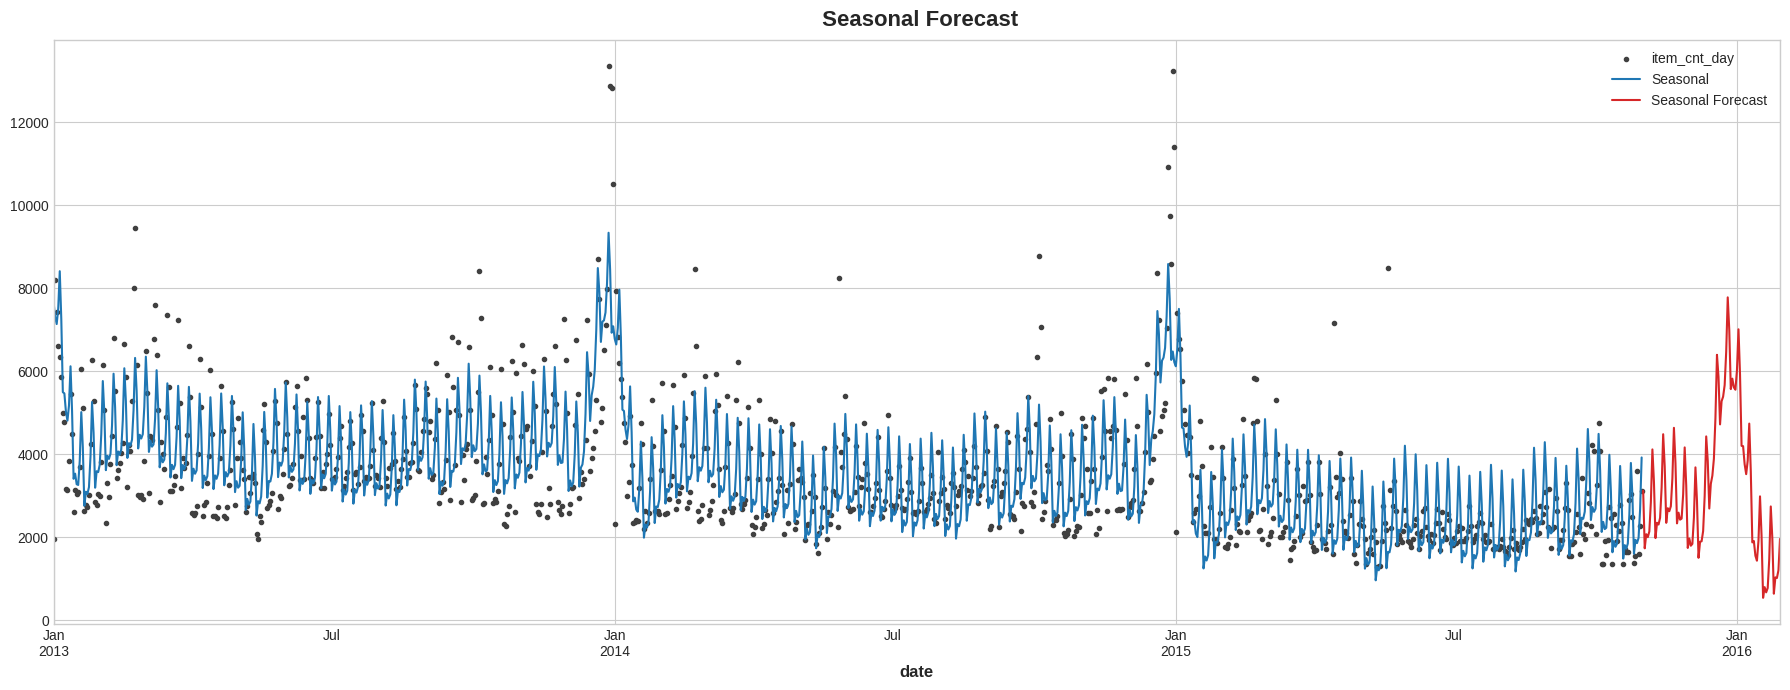

In [36]:

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title=" Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [37]:
y_fore

2015-11-01    3117.927276
2015-11-02    1729.981401
2015-11-03    2069.774037
2015-11-04    1998.996651
2015-11-05    2135.938206
                 ...     
2016-01-25     635.983830
2016-01-26    1029.753672
2016-01-27    1014.022732
2016-01-28    1203.066985
2016-01-29    1957.045996
Freq: D, Length: 90, dtype: float64

Removing from a series its trend or seasons is called detrending or deseasonalizing the series.

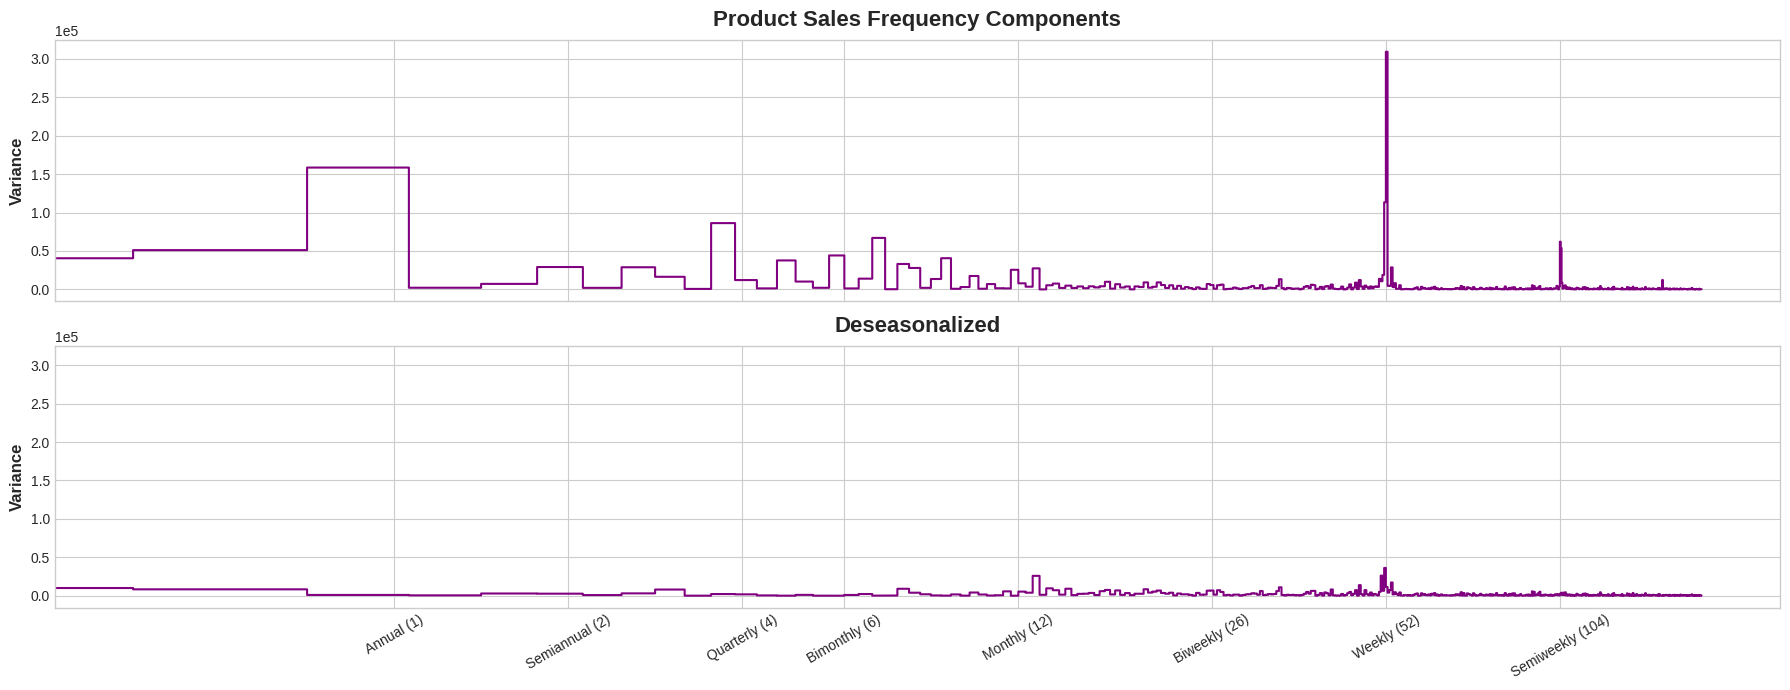

In [38]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

Based on these periodograms, how effectively does it appear your model captured the seasonality in Average Sales? Does the periodogram agree with the time plot of the deseasonalized series?

The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, **we can see that our model was able to capture the seasonal variation in the dataset**.

### Create holiday features

In [39]:
ru_holidays = holidays.RU()

In [40]:
'01-01-2013' in ru_holidays

True

In [41]:
ru_holidays.get('2013-01-01')

'New Year Holidays'

In [42]:
dates = pd.DataFrame(sales['date'])

In [43]:
dates

date
0       2013-01-02
1       2013-01-03
2       2013-01-05
3       2013-01-06
4       2013-01-15
...            ...
2935844 2015-10-10
2935845 2015-10-09
2935846 2015-10-14
2935847 2015-10-22
2935848 2015-10-03

[2935849 rows x 1 columns]

In [44]:
dates['is_holiday']= dates['date'].map(lambda x: x in ru_holidays)

In [45]:
holidays = dates[dates['is_holiday']== True]

In [46]:
holidays = holidays.drop_duplicates()
holidays['is_holiday'] = holidays['is_holiday'].astype('int')
holidays

date  is_holiday
0       2013-01-02           1
1       2013-01-03           1
2       2013-01-05           1
3       2013-01-06           1
7       2013-01-04           1
12      2013-01-07           1
13      2013-01-08           1
7554    2013-01-01           1
115699  2013-02-23           1
224324  2013-03-08           1
439775  2013-05-09           1
439787  2013-05-01           1
531526  2013-06-12           1
1027587 2013-11-04           1
1267562 2014-01-02           1
1267567 2014-01-03           1
1267568 2014-01-08           1
1267569 2014-01-05           1
1267572 2014-01-07           1
1267577 2014-01-04           1
1267589 2014-01-01           1
1267591 2014-01-06           1
1366936 2014-02-23           1
1456758 2014-03-08           1
1627380 2014-05-09           1
1627434 2014-05-01           1
1706001 2014-06-12           1
2106212 2014-11-04           1
2323423 2015-01-07           1
2323424 2015-01-02           1
2323427 2015-01-04           1
2323433 2015-01-06           1
2323434 2015-01-03           1
2323435 2015-01-05           1
2323445 2015-01-01           1
2323457 2015-01-08           1
2411949 2015-02-23           1
2483818 2015-03-08           1
2610010 2015-05-01           1
2610018 2015-05-09           1
2664554 2015-06-12           1

In [47]:
holidays = holidays.set_index('date').to_period('D')

From a plot of the deseasonalized count of items Sold, it appears these holidays could have some predictive power.

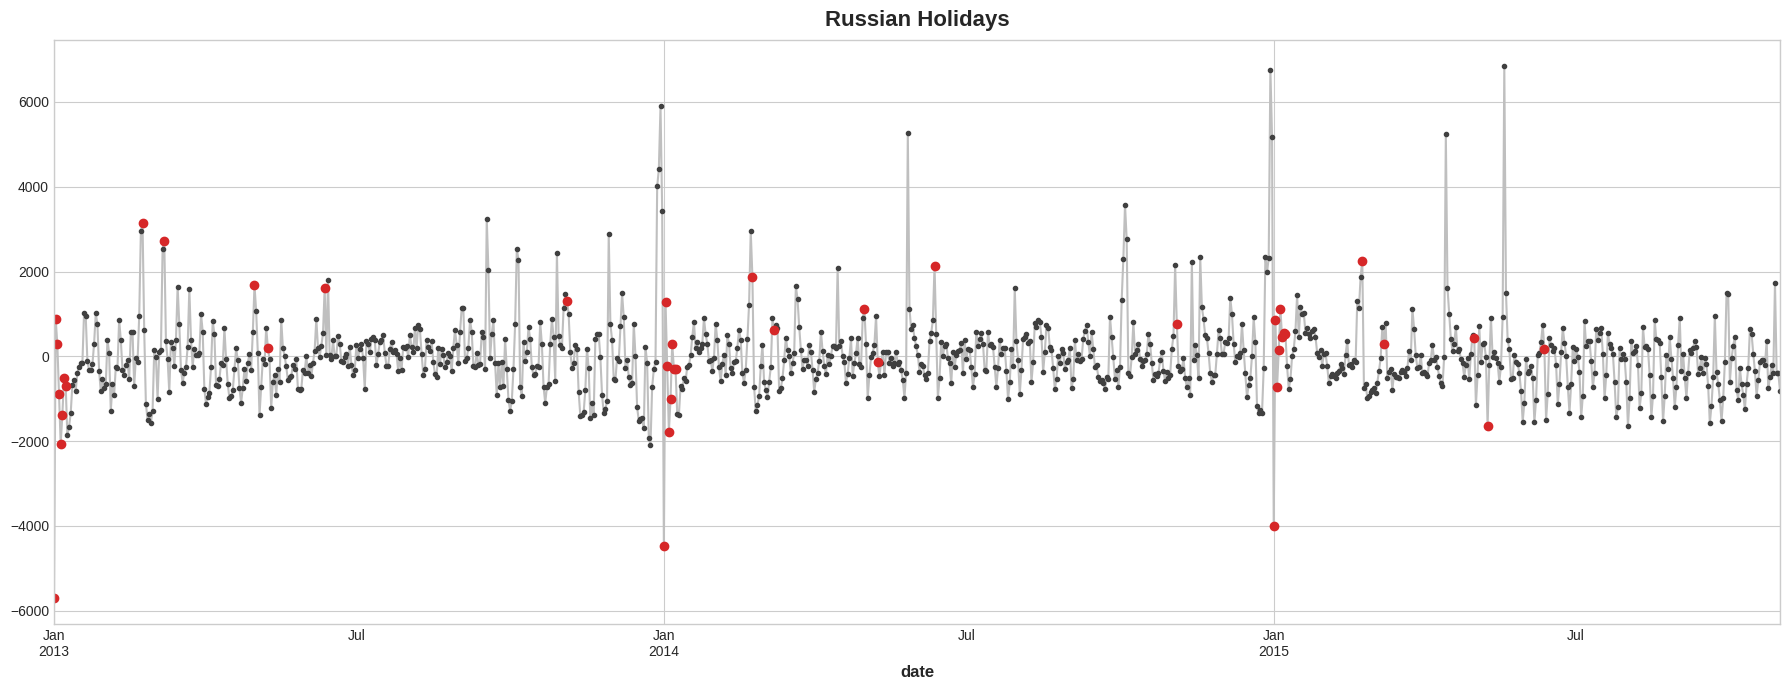

In [48]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('Russian Holidays');

In [49]:
from sklearn.preprocessing import OneHotEncoder

X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

In [50]:
X2

const   trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                        
2013-01-01    1.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2013-01-02    1.0     2.0     1.0     0.0     0.0     0.0     0.0     0.0   
2013-01-03    1.0     3.0     0.0     1.0     0.0     0.0     0.0     0.0   
2013-01-04    1.0     4.0     0.0     0.0     1.0     0.0     0.0     0.0   
2013-01-05    1.0     5.0     0.0     0.0     0.0     1.0     0.0     0.0   
...           ...     ...     ...     ...     ...     ...     ...     ...   
2015-10-27    1.0  1030.0     0.0     0.0     0.0     0.0     0.0     0.0   
2015-10-28    1.0  1031.0     1.0     0.0     0.0     0.0     0.0     0.0   
2015-10-29    1.0  1032.0     0.0     1.0     0.0     0.0     0.0     0.0   
2015-10-30    1.0  1033.0     0.0     0.0     1.0     0.0     0.0     0.0   
2015-10-31    1.0  1034.0     0.0     0.0     0.0     1.0     0.0     0.0   

            sin(1,freq=A-DEC)  cos(1,freq=A-DEC)  ...  cos(8,freq=A-DEC)  \
date                                              ...                      
2013-01-01           0.000000           1.000000  ...           1.000000   
2013-01-02           0.017213           0.999852  ...           0.990532   
2013-01-03           0.034422           0.999407  ...           0.962309   
2013-01-04           0.051620           0.998667  ...           0.915864   
2013-01-05           0.068802           0.997630  ...           0.852078   
...                       ...                ...  ...                ...   
2015-10-27          -0.907014           0.421101  ...          -0.944188   
2015-10-28          -0.899631           0.436651  ...          -0.890028   
2015-10-29          -0.891981           0.452072  ...          -0.819015   
2015-10-30          -0.884068           0.467359  ...          -0.732494   
2015-10-31          -0.875892           0.482508  ...          -0.632103   

            sin(9,freq=A-DEC)  cos(9,freq=A-DEC)  sin(10,freq=A-DEC)  \
date                                                                   
2013-01-01           0.000000           1.000000            0.000000   
2013-01-02           0.154309           0.988023            0.171293   
2013-01-03           0.304921           0.952378            0.337523   
2013-01-04           0.448229           0.893919            0.493776   
2013-01-05           0.580800           0.814046            0.635432   
...                       ...                ...                 ...   
2015-10-27           0.717677          -0.696376            0.933837   
2015-10-28           0.601624          -0.798779            0.981306   
2015-10-29           0.471160          -0.882048            0.999769   
2015-10-30           0.329408          -0.944188            0.988678   
2015-10-31           0.179767          -0.983709            0.948362   

            cos(10,freq=A-DEC)  sin(11,freq=A-DEC)  cos(11,freq=A-DEC)  \
date                                                                     
2013-01-01            1.000000            0.000000            1.000000   
2013-01-02            0.985220            0.188227            0.982126   
2013-01-03            0.941317            0.369725            0.929141   
2013-01-04            0.869589            0.538005            0.842942   
2013-01-05            0.772157            0.687053            0.726608   
...                        ...                 ...                 ...   
2015-10-27            0.357698            0.068802            0.997630   
2015-10-28            0.192452            0.255353            0.966848   
2015-10-29            0.021516            0.432776            0.901502   
2015-10-30           -0.150055            0.594727            0.803928   
2015-10-31           -0.317191            0.735417            0.677615   

            sin(12,freq=A-DEC)  cos(12,freq=A-DEC)  is_holiday  
date                                                    

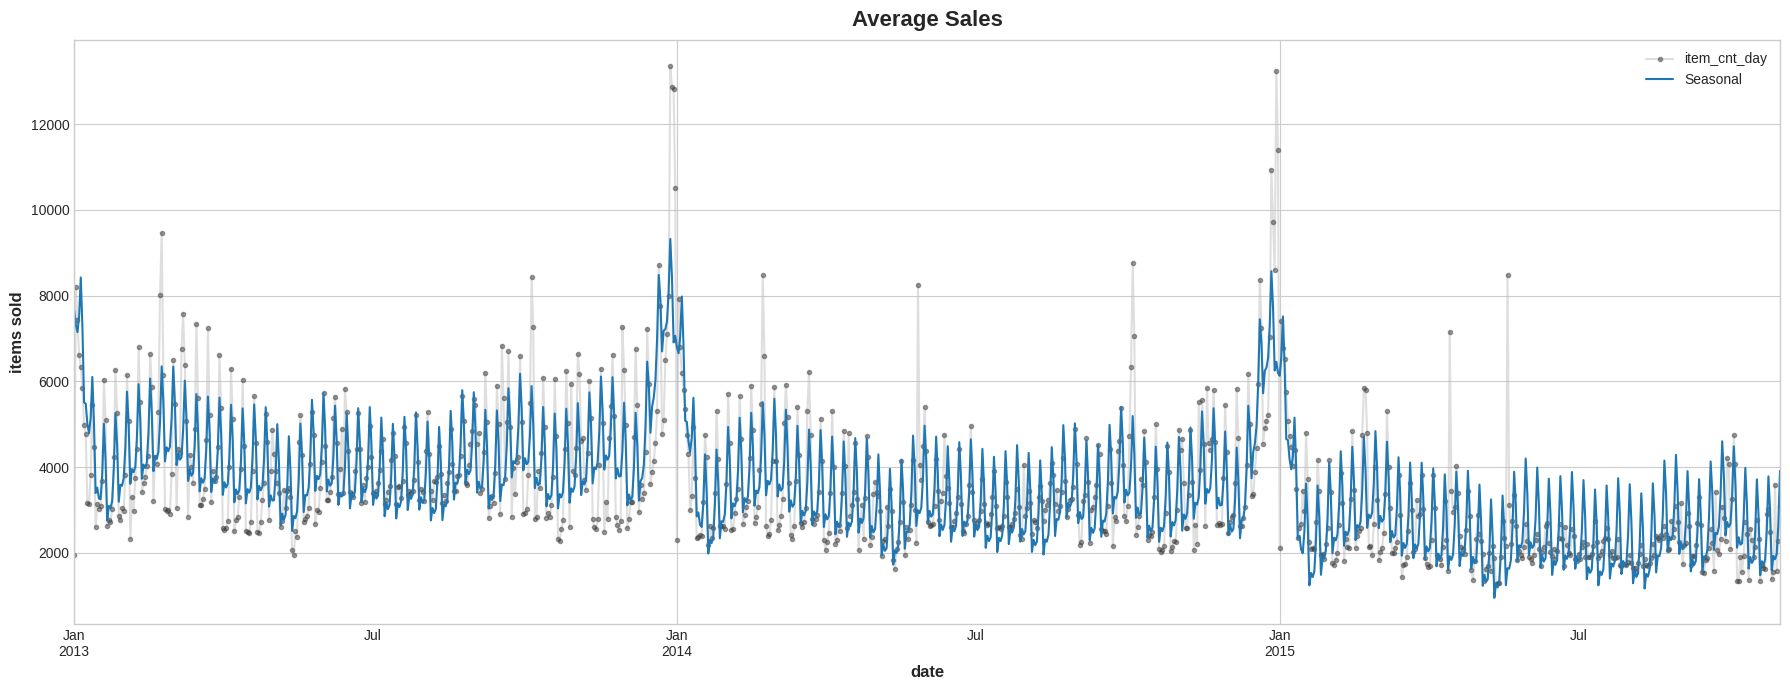

In [51]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

# Time Series as Features

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely cyclic behavior, we'll start by deseasonalizing the series.

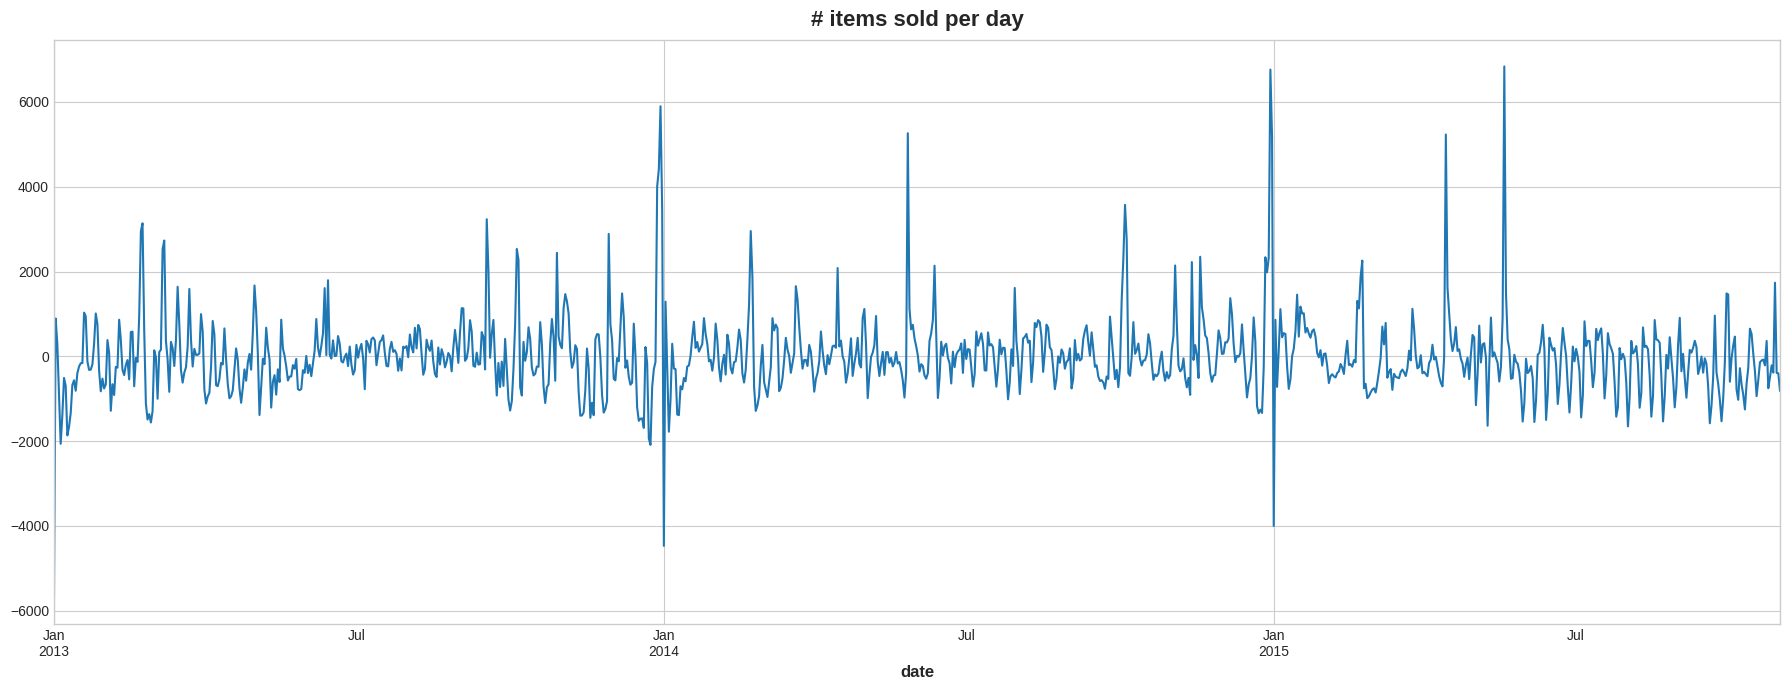

In [52]:
ax = y_deseason.plot()
ax.set_title("# items sold per day");

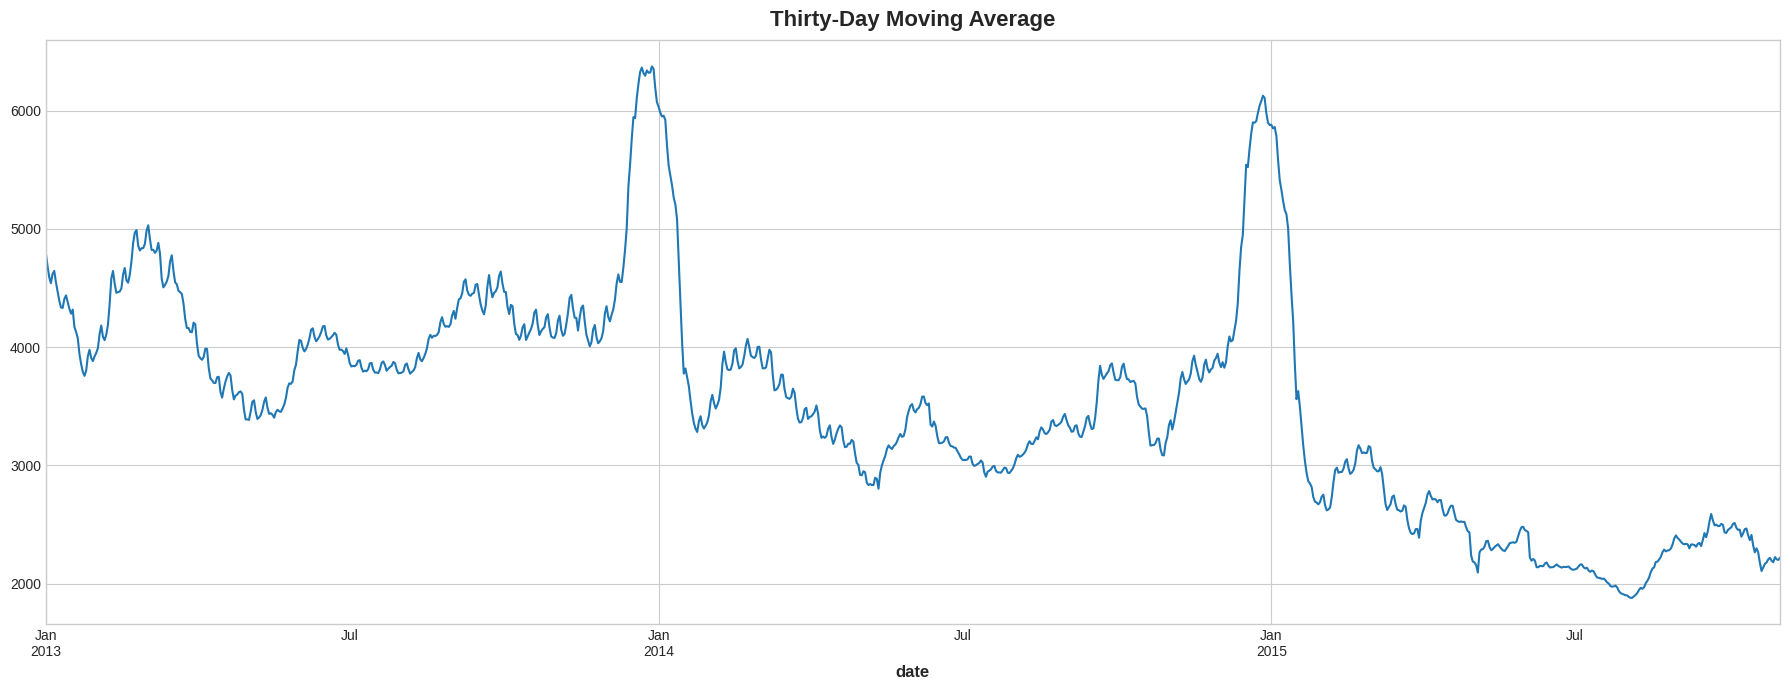

In [53]:
y_ma = y.rolling(window= 30,
                 min_periods=15,
                 center= True,
        ).mean()


# Plot
ax = y_ma.plot()
ax.set_title("Thirty-Day Moving Average");

Let's examine our deseasonalized series for serial dependence. Take a look at the partial autocorrelation correlogram and lag plot.

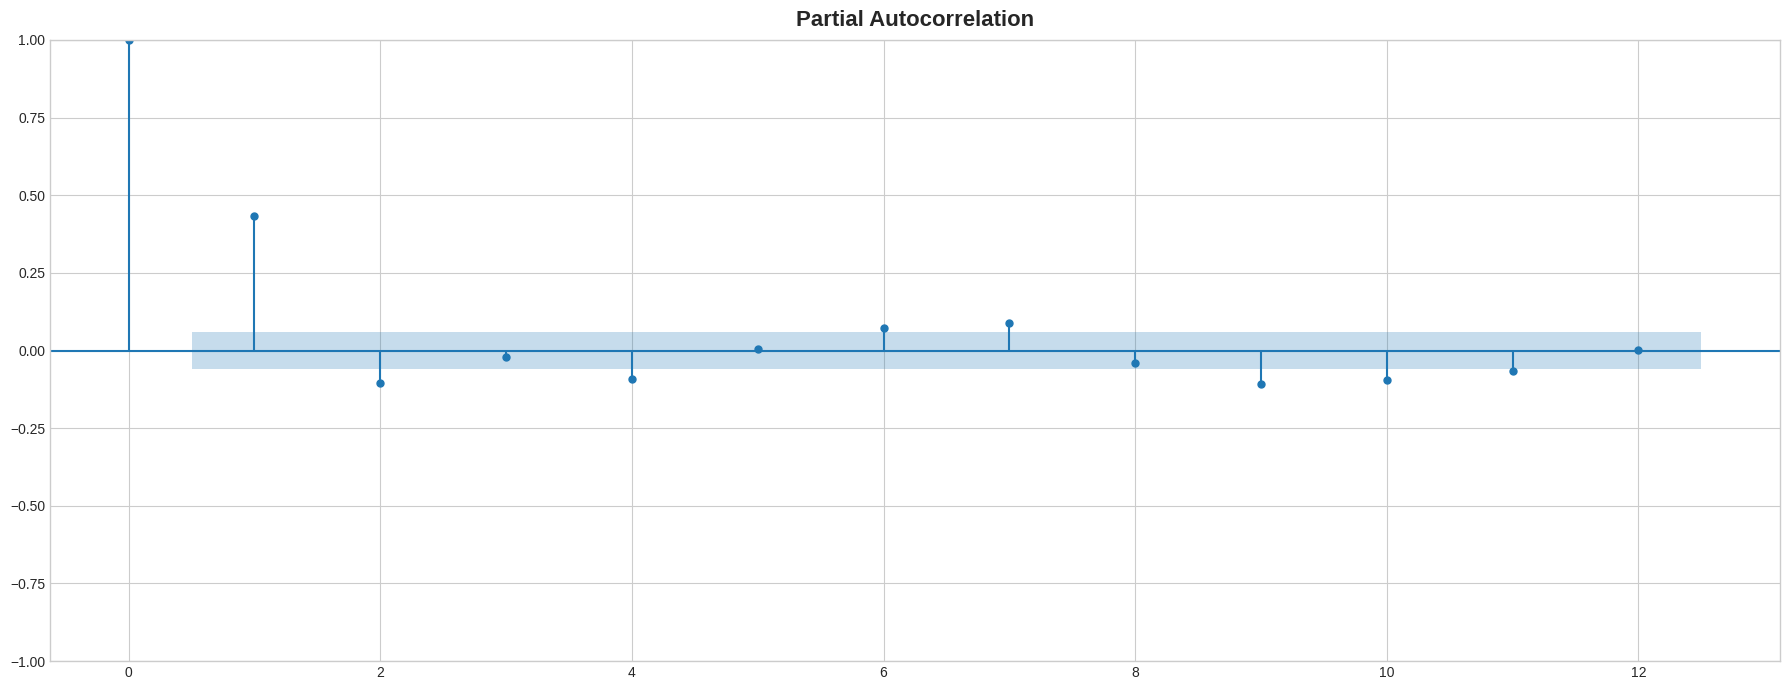

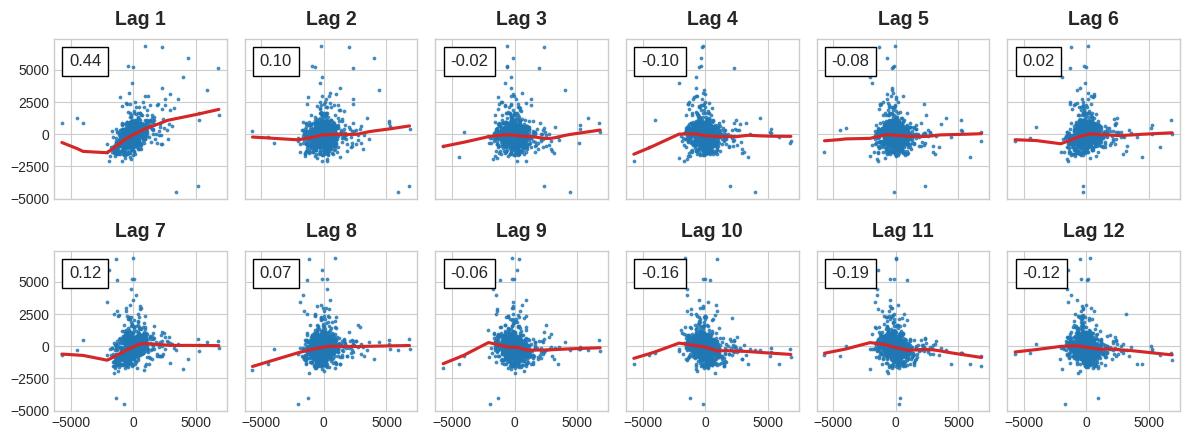

In [54]:
plot_pacf(y_deseason, lags=12);
plot_lags(y_deseason, lags=12, nrows=2);

The correlogram indicates the first lag is likely to be significant

In [55]:
y = y.to_frame()

In [56]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(y.item_cnt_day, lags=1)
X = X.fillna(0.0)

In [57]:
# Create target series and data splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train).squeeze(), index=y_train.index)
y_fore = pd.Series(model.predict(X_test).squeeze(), index=y_test.index)

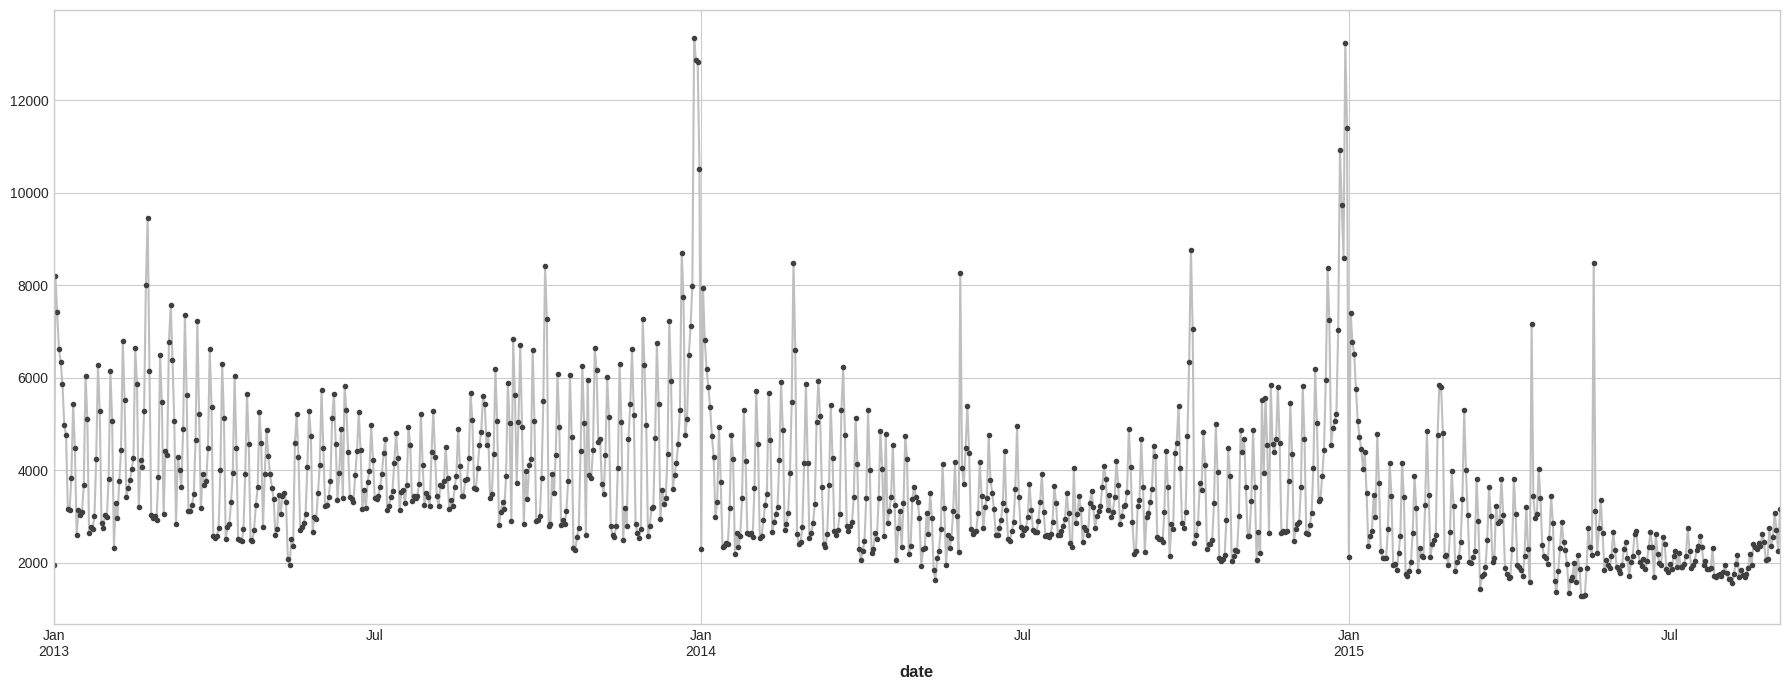

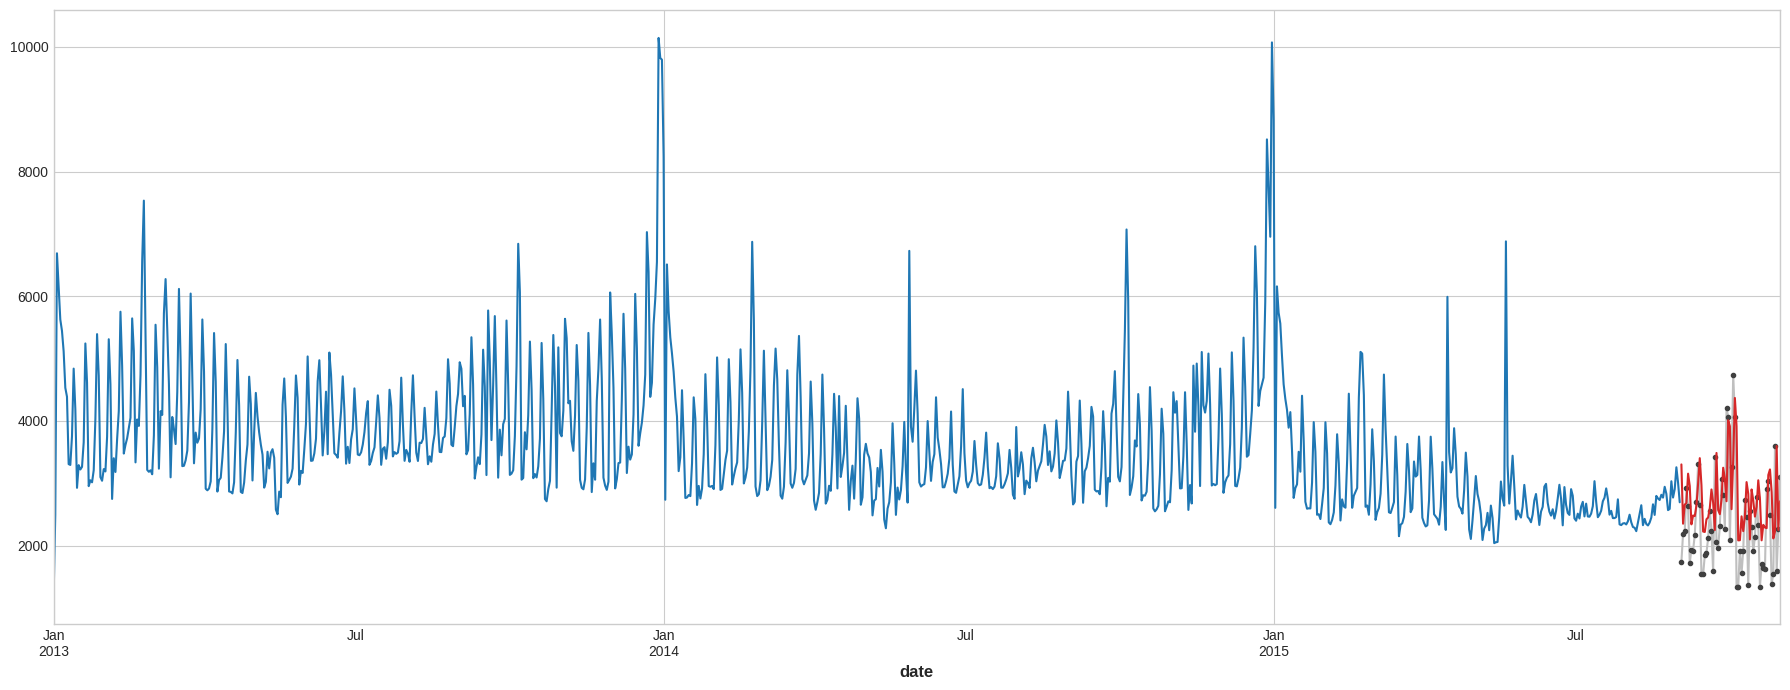

In [58]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')


Looking just at the forecast values, we can see how our model needs a time step to react to sudden changes in the target series. This is a common limitation of models using only lags of the target series as features.

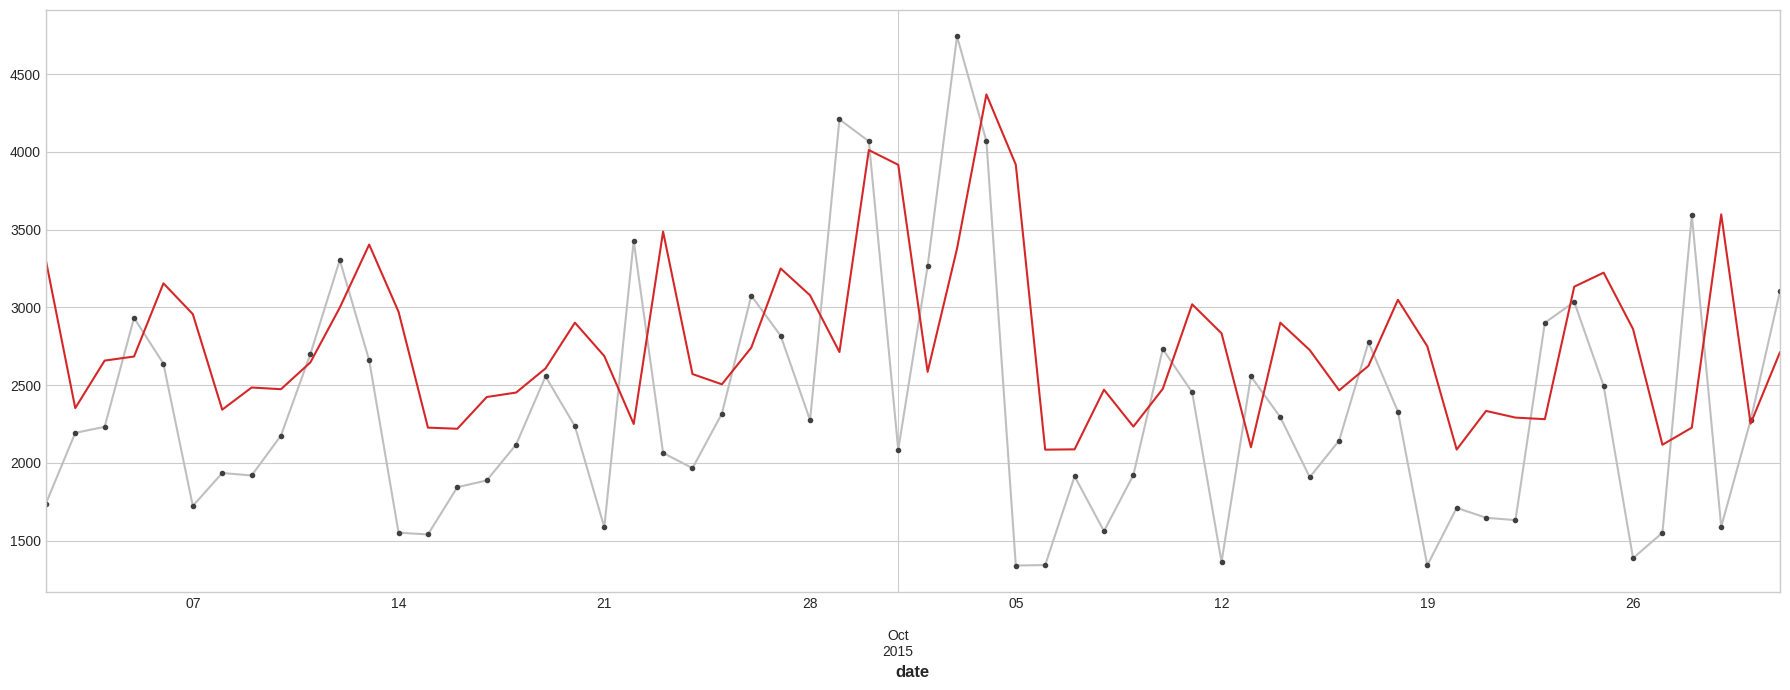

In [59]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

To improve the forecast we could try to find leading indicators, time series that could provide an "early warning" for changes in sales.

# Hybrid Models

### **notes:**

> It's possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.

> If we use the first model to learn the trend, we generally wouldn't need a trend feature for the second model, for example.

> While it's possible to use more than two models, in practice it doesn't seem to be especially helpful. In fact, the most common strategy for constructing hybrids is the one we've just described: a simple (usually linear) learning algorithm followed by a complex, non-linear learner like GBDTs or a deep neural net, the simple model typically designed as a "helper" for the powerful algorithm that follows.

There are generally two ways a regression algorithm can make predictions: either by transforming the features or by transforming the target. Feature-transforming algorithms learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. Linear regression and neural nets are of this kind.

Target-transforming algorithms use the features to group the target values in the training set and make predictions by averaging values in a group; a set of feature just indicates which group to average. Decision trees and nearest neighbors are of this kind.


> *The important thing is this: feature transformers generally can extrapolate target values beyond the training set given appropriate features as inputs, but the predictions of target transformers will always be bound within the range of the training set. If the time dummy continues counting time steps, linear regression continues drawing the trend line. Given the same time dummy, a decision tree will predict the trend indicated by the last step of the training data into the future forever. Decision trees cannot extrapolate trends. Random forests and gradient boosted decision trees (like XGBoost) are ensembles of decision trees, so they also cannot extrapolate trends.*

> Use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals. To hybridize a neural net (a feature transformer), we could instead include the predictions of another model as a feature, which the neural net would then include as part of its own predictions. The method of fitting to residuals is actually the same method the gradient boosting algorithm uses.

While the linear regression algorithm is capable of multi-output regression, the XGBoost algorithm is not. To predict multiple series at once with XGBoost, we'll instead convert these series from wide format, with one time series per column, to long format, with series indexed by categories along rows.